In [140]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import dill

In [141]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

# Plotting from section 13 of `2.1.1 run same mixtures through Cibersort for comparison.ipynb`

In [142]:
# example_result := cibersort

[
    merged_samples, cleaner_gt, friendly_mixture_descriptions, example_result,
    cib_class_names, rollup_groundtruth, rollupsums_df, col_order, rollups
] = pickle.load(open('/modelcache/experiments/tmp_2.1.1_plotting.pkl', 'rb'))

In [146]:
print('Cibersort Diagnostics for hyper (inserted in google doc):')
for key,row in example_result[['RMSE', 'P-value']].iterrows():
    print("mixture %d" % (key+1))
    print("{{{mix%d_rmse:%0.2f}}}" % (key+1, row['RMSE']))
    print("{{{mix%d_pval:%0.1f}}}" % (key+1, row['P-value']))
example_result[['RMSE', 'P-value']].iloc[[6,1,9]]

Cibersort Diagnostics for hyper (inserted in google doc):
mixture 1
{{{mix1_rmse:0.28}}}
{{{mix1_pval:0.0}}}
mixture 2
{{{mix2_rmse:0.34}}}
{{{mix2_pval:0.0}}}
mixture 3
{{{mix3_rmse:0.30}}}
{{{mix3_pval:0.0}}}
mixture 4
{{{mix4_rmse:0.33}}}
{{{mix4_pval:0.0}}}
mixture 5
{{{mix5_rmse:0.27}}}
{{{mix5_pval:0.0}}}
mixture 6
{{{mix6_rmse:0.34}}}
{{{mix6_pval:0.0}}}
mixture 7
{{{mix7_rmse:0.45}}}
{{{mix7_pval:0.0}}}
mixture 8
{{{mix8_rmse:0.44}}}
{{{mix8_pval:0.0}}}
mixture 9
{{{mix9_rmse:0.41}}}
{{{mix9_pval:0.0}}}
mixture 10
{{{mix10_rmse:0.49}}}
{{{mix10_pval:0.0}}}


,RMSE,P-value
6,0.452792,0.0
1,0.339896,0.0
9,0.486806,0.0


In [147]:
#sns.set_context('paper')
sns.set_style("darkgrid")

In [148]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

In [149]:
def extract_values_for_mixture_by_id(key):
    """
    key: 1-indexed, meaning mixture 1 to mixture 10
    
    based on:
    for (key, grp), \
            (_, groundtruth_base), \
            friendly_title, \
            (_, cib_vals_base), \
            (mixID_rolledup, groundtruth_rolledup), \
            (_, cib_vals_rolledup) in zip(merged_samples.groupby('sample_id'),
                                          cleaner_gt.iterrows(),
                                          #friendly_mixture_descriptions2,
                                          friendly_mixture_descriptions,
                                          example_result[cib_class_names].iterrows(),
                                          rollup_groundtruth.groupby('mixID'),
                                          rollupsums_df.iterrows()
    """
    grp = merged_samples[merged_samples['sample_id'] == key]
    groundtruth_base = cleaner_gt.iloc[key-1]
    cib_vals_base = example_result[cib_class_names].iloc[key-1]
    groundtruth_rolledup = rollup_groundtruth[rollup_groundtruth['mixID'] == key-1]
    cib_vals_rolledup = rollupsums_df.iloc[key-1]
    
    return (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup)

In [150]:
def plot_single_mixture_results(mixture_info, friendly_title):
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # http://seaborn.pydata.org/tutorial/color_palettes.html
    #sns.palplot(flatui)
    paired_colors = sns.color_palette("Paired_r", 12)
    #sns.palplot(paired_colors)
    
    (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup) = mixture_info

    with sns.plotting_context('paper'):
        f, ax = plt.subplots( figsize=(12,8))
        g = sns.boxplot(data = grp,
                       y='subset_name',
                       x='estimate',
                       ax=ax,
                       hue='type',
                       order=col_order,
                        # some additional parameters that we think may help:
                        saturation=1,
                        linewidth=1, # not sure about this one
                        dodge=False, # avoid hue nesting
                       #palette=[flatui[0], flatui[1]]
                        palette=paired_colors[0:2]
                       )
        g.set_title(friendly_title) 

        # ground truth
        gt1 = pd.DataFrame(groundtruth_base).reset_index()
        gt1.columns = ['rollup', 'estimate']
        gt1['type'] = 'subset'
        gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
        gt2['type'] = 'rollup'
        gt = pd.concat([gt1, gt2])

        sns.stripplot(
            x="estimate",
            y="rollup",
            data=gt,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(5, 1),
            #palette=[flatui[5], flatui[3]],
            palette=paired_colors[2:4],
            zorder=5,
            jitter=False,
            label='Ground Truth' # https://github.com/mwaskom/seaborn/issues/940 -- without this line, the stars aren't shown in legend entries made by "hue" param; instead you get a ton of dupe Ground Truth star labels
        )

        # add cibersort points
        cb_base = pd.DataFrame(cib_vals_base).reset_index()
        cb_base.columns = ['SubSet', 'estimate']
        cb_base['type'] = 'subset'

        cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
        cb_rolledup.columns = ['SubSet', 'estimate']
        cb_rolledup['type'] = 'rollup'

        cb = pd.concat([cb_base, cb_rolledup])
        cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

        sns.stripplot(
            x="estimate",
            y="SubSet",
            data=cb,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(3, 0),
            #palette=[flatui[2], flatui[4]],
            palette=paired_colors[4:6],
            zorder=6,
            jitter=False,
            label='Cibersort' # see above again re this label parameter
        )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type')
        g.set_xbound(0, 1)

        # show legend, and subselect because stripplot adds one legend item per point it appears
        handles, labels = ax.get_legend_handles_labels()
        """
        want legend items:
        * infino samples: items 0, 1
        * ground truth stars: items 2, 3
        * cibersort triangles: items 2+len(col_order)+2, 2+len(col_order)+2+1
        """
        chosen_idx = [1,0, 2,3, 2+len(col_order)+2, 2+len(col_order)+2+1]
        chosen_handles = [handles[i] for i in chosen_idx]
        #chosen_labels = [labels[i] for i in chosen_idx]
        chosen_labels = ['Infino (sums)', 'Infino', 'Ground Truth (sums)', 'Ground Truth', 'Cibersort (sums)', 'Cibersort']
        legend = ax.legend(
            chosen_handles,
            chosen_labels,
            loc='lower right',
            frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        # shade background
        #fill1 = plt.axhspan('B', 'CD4 T', facecolor='0.5', alpha=0.5)
        fill1 = plt.axhspan(-0.5, 3.5, facecolor='0.8', alpha=0.3)
        fill3 = plt.axhspan(11.5, 15.5, facecolor='0.8', alpha=0.3)

        # improve label format
        # https://stackoverflow.com/a/34426167/130164
        for label in ax.get_yticklabels():
            if label.get_text() in rollups.keys():
                label.set_size(15)
                label.set_backgroundcolor("yellow")
                label.set_weight("bold")
                label.set_color("red")
            else:
                label.set_fontstyle("italic")
                label.set_weight("bold")


        return f,ax
        

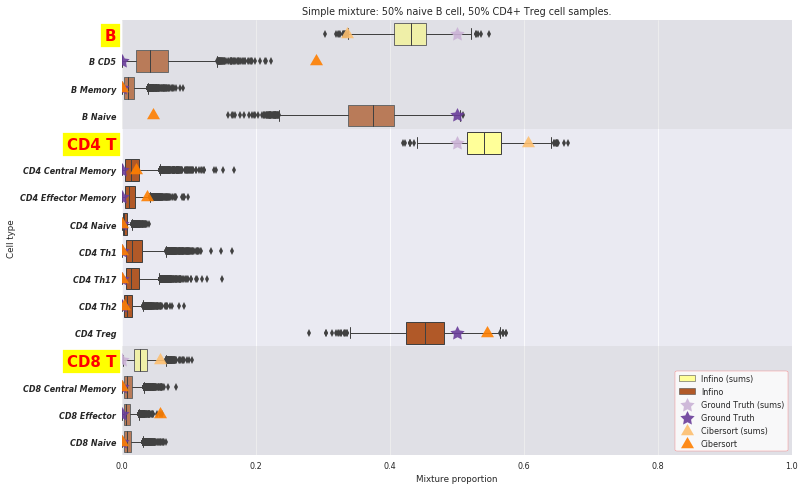

In [151]:
f,ax = plot_single_mixture_results(extract_values_for_mixture_by_id(7),
                                   'Simple mixture: 50% naive B cell, 50% CD4+ Treg cell samples.')

# Quantification of results

TODO(Eliza)

See https://github.com/jburos/simtest_jm/blob/master/docker_image/recover_params.function.R and https://github.com/jburos/simtest_jm/blob/master/simulation_results_etaslope.md.

> the first is a script that computes the pctile of the true value in the posterior distribution. the second shows an example plot of what this looks like over a few simulated runs. 

In [153]:
from scipy.stats import percentileofscore

In [156]:
cleaner_gt.index = range(1, len(cleaner_gt)+1)
cleaner_gt

,B CD5,B Memory,B Naive,CD4 Central Memory,CD4 Effector Memory,CD4 Naive,CD4 Th1,CD4 Th17,CD4 Th2,CD4 Treg,CD8 Central Memory,CD8 Effector,CD8 Naive
1,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
5,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
6,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
7,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0
8,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
9,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0
10,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0


In [157]:
infino_percentiles = []

for sample_id in range(1, len(example_result)+1):
    for subset_type in col_order:
        subset_samples = np.array(merged_samples[(merged_samples['subset_name'] == subset_type) &
                                        (merged_samples['sample_id'] == sample_id)]['estimate'])

        # Grab the GT values for the fruit rollups
        if subset_type in rollups.keys():
            try:
                
                gt_value = rollup_groundtruth[(rollup_groundtruth['mixID'] == (sample_id-1)) &
                              (rollup_groundtruth['rollup'] == subset_type)]['estimate'].values[0]   
            except Exception as e:
                import pdb; pdb.set_trace()
                print(e)
                print(subset_type)
                print(rollup_groundtruth[(rollup_groundtruth['mixID'] == sample_id) &
                              (rollup_groundtruth['rollup'] == subset_type)]['estimate'])
        else: # Grab the GT values for the subsets
            gt_value = cleaner_gt.ix[sample_id, subset_type]
        
        # Now calculate percentile of gt_value in subset_samples
        pctile = percentileofscore(a=subset_samples, score=gt_value, kind='weak')
        
        
        infino_percentiles.append({'sample_id':sample_id, 
         'subset_type': subset_type, 
         'tv_percentile': pctile})

In [158]:
infino_percentiles_df = pd.DataFrame(infino_percentiles)

In [159]:
infino_percentiles_df

,sample_id,subset_type,tv_percentile
0,1,B,100.000
1,1,B CD5,0.000
2,1,B Memory,100.000
3,1,B Naive,0.000
4,1,CD4 T,0.000
5,1,CD4 Central Memory,0.000
6,1,CD4 Effector Memory,0.000
7,1,CD4 Naive,0.000
8,1,CD4 Th1,0.000
9,1,CD4 Th17,0.000


In [160]:
infino_percentiles_df.to_csv('2.1.1_tv-percentiles.csv', index=False)